<a href="https://colab.research.google.com/github/Mayurd9/CNN-Classification/blob/main/MNIST/MNIST_CNN_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# $\textbf{Loading the Data}$

In [2]:
train_data=datasets.MNIST(root='data',train=True,download=True,transform=ToTensor(),target_transform=None)
test_data=datasets.MNIST(root='data',train=False,download=True,transform=ToTensor(),target_transform=None)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4554128.71it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 132571.73it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1079228.98it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3417135.21it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
print(len(train_data), len(test_data))
print(type(train_data[0]))
print(train_data[0][0].shape)

60000 10000
<class 'tuple'>
torch.Size([1, 28, 28])


In [4]:
train_data.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [5]:
np.unique(train_data.targets)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

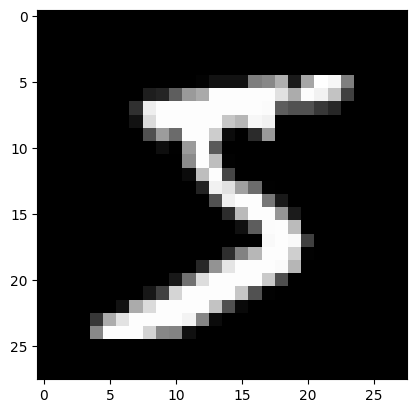

In [6]:
plt.imshow(train_data[0][0].squeeze(),cmap='gray')

# $\textbf{Dataloader}$

In [7]:
train_dataloader=DataLoader(train_data,batch_size=10, shuffle=True)
test_dataloader=DataLoader(test_data,batch_size=10,shuffle=True)

In [8]:
len(train_dataloader),len(test_dataloader)

(6000, 1000)

In [9]:
type(next(iter(train_dataloader)))

list

In [10]:
next(iter(train_dataloader))[0].shape

torch.Size([10, 1, 28, 28])

In [11]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# $\textbf{Making model}$

In [27]:
class MNISTmodel(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_block1=nn.Sequential(nn.Conv2d(in_channels=1,out_channels=20,kernel_size=5, stride=1,padding=0),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2))
    self.conv_block2=nn.Sequential(nn.Conv2d(in_channels=20,out_channels=40,kernel_size=5,stride=1,padding=0),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2))
    self.fullyconnected=nn.Sequential(nn.Flatten(),
                                      nn.Linear(in_features=40*4*4,out_features=1000),
                                      nn.Dropout(p=0.5),
                                      nn.ReLU(),
                                      nn.Linear(in_features=1000,out_features=1000),
                                      nn.Dropout(p=0.5),
                                      nn.ReLU(),
                                      nn.Linear(in_features=1000,out_features=10),
                                      nn.Dropout(p=0.5),
                                      nn.ReLU())
  def forward(self,x):
    z=self.conv_block1(x)
    z=self.conv_block2(z)
    z=self.fullyconnected(z)
    return z

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0=MNISTmodel().to(device)
model_0

MNISTmodel(
  (conv_block1): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fullyconnected): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=640, out_features=1000, bias=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=1000, out_features=1000, bias=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): ReLU()
    (7): Linear(in_features=1000, out_features=10, bias=True)
    (8): Dropout(p=0.5, inplace=False)
    (9): ReLU()
  )
)

In [29]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_0.parameters(),lr=0.03)

In [30]:
def accuracy_fn(y_true,y_pred):
  return (torch.sum(y_true==y_pred)/len(y_true)).item()*100

# $\textbf{Training}$

In [31]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=40

for epoch in tqdm(range(epochs)):

  train_loss,train_acc=0,0
  for batch, (X,y) in enumerate(train_dataloader):
    model_0.train()
    X,y=X.to(device),y.to(device)
    y_logits=model_0(X)
    loss=loss_fn(y_logits,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss+=loss

    model_0.eval()
    with torch.inference_mode():
      train_acc+=accuracy_fn(y_true=y,y_pred=torch.argmax(torch.softmax(model_0(X),dim=1),dim=1))/len(train_dataloader)

  train_loss/=len(train_dataloader)

  model_0.eval()
  with torch.inference_mode():
    test_loss,test_acc=0,0
    for X,y in test_dataloader:
      X,y=X.to(device),y.to(device)
      test_logits=model_0(X)
      test_preds=torch.argmax(torch.softmax(test_logits,dim=1),dim=1)
      test_loss += loss_fn(test_logits,y)
      test_acc += accuracy_fn(y_true=y,y_pred=test_preds)

    test_loss/=len(test_dataloader)
    test_acc/=len(test_dataloader)

  print(f"Epoch:{epoch},Train loss:{train_loss}, Test loss:{test_loss}, Train accuracy:{train_acc}, Test accuracy:{test_acc}")

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch:0,Train loss:1.5037524700164795, Test loss:0.48621031641960144, Train accuracy:80.46000141911195, Test accuracy:86.78000164330005
Epoch:1,Train loss:1.3102200031280518, Test loss:0.15206673741340637, Train accuracy:90.5800012941143, Test accuracy:98.55000045895576
Epoch:2,Train loss:1.1985360383987427, Test loss:0.11274856328964233, Train accuracy:99.16000027854834, Test accuracy:98.8400003671646
Epoch:3,Train loss:1.1904634237289429, Test loss:0.07764433324337006, Train accuracy:99.38166687786166, Test accuracy:99.08000030517579
Epoch:4,Train loss:1.1751344203948975, Test loss:0.10758793354034424, Train accuracy:99.46333351929567, Test accuracy:98.98000032901764
Epoch:5,Train loss:1.1818174123764038, Test loss:0.08965731412172318, Train accuracy:99.55166682501215, Test accuracy:99.11000028848648
Epoch:6,Train loss:1.1793572902679443, Test loss:0.07661239057779312, Train accuracy:99.60000014205352, Test accuracy:98.99000034332275
Epoch:7,Train loss:1.1806504726409912, Test loss:0

In [32]:
torch.save(obj=model_0.state_dict(),f='model_0')

# $\textbf{Evaluating the model}$

In [33]:
def eval_model(model,dataloader):
  model.eval()
  with torch.inference_mode():
    loss,acc=0,0
    for (X,y) in tqdm(dataloader):
      X,y=X.to(device),y.to(device)
      logits=model(X)
      preds=torch.argmax(torch.softmax(logits,dim=1),dim=1)
      loss+=loss_fn(logits,y)
      acc+=accuracy_fn(y,preds)
    loss/=len(dataloader)
    acc/=len(dataloader)

  print(f"Accuracy:{acc},loss:{loss}")

In [34]:
model_0=MNISTmodel().to(device)

In [35]:
model_0.load_state_dict(torch.load(f='model_0'))

<All keys matched successfully>

In [36]:
eval_model(model_0,test_dataloader)

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy:99.26000024080277,loss:0.03683239966630936


# $\textbf{Testing on Random Image}$

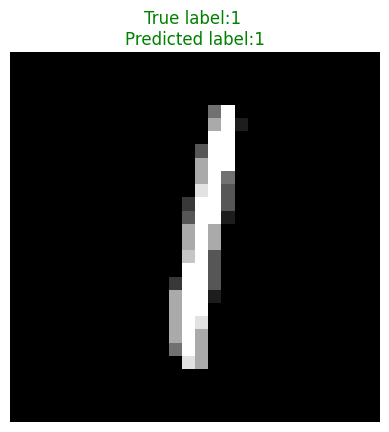

In [37]:
image,label=test_data[np.random.randint(0,10000)]
pred_label=torch.argmax(torch.softmax(model_0(image.unsqueeze(dim=0).to(device)),dim=1),dim=1)
plt.imshow(image.squeeze(),cmap='gray')
plt.axis(False)
if label==pred_label:
  plt.title(f"True label:{label} \nPredicted label:{pred_label.item()}",c='g')
else:
  plt.title(f"True label:{label} \nPredicted label:{pred_label.item()}",c='r')